In [1]:
from masters.env_wrapper import make_wrapped_env
from masters.networks.mlp import make_mlp
from masters.a2c.trainer import A2CTrainer
from masters.a2c.agent import A2CAgent
from masters.data import cartpole_info
from bindsnet.encoding.encoders import GaussianReceptiveFieldsEncoder
from IPython.display import Image
import torch
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
encoder = GaussianReceptiveFieldsEncoder(encoding_info=cartpole_info, intensity=200)

In [33]:
actor = make_mlp(
    input_shape=[80],
    output_shape=[10, 2],
    nu=[1e-3, 1e-1],
    norm=0.6,
#     hidden_layer_shapes=[[100]],
    time=100,
    dev=True
)
critic = make_mlp(
    input_shape=[80],
    output_shape=[1],
    nu=[1e-3, 1e-1],
    norm=0.6,
#     hidden_layer_shapes=[[100]],
    time=100,
    dev=True
)
prev_critic = make_mlp(
    input_shape=[80],
    output_shape=[1],
    nu=[1e-3, 1e-1],
    norm=0.6,
#     hidden_layer_shapes=[[100]],
    time=100,
    dev=True
)

In [34]:
agent = A2CAgent(
    actor=actor,
    critic=critic,
    prev_critic=prev_critic,
    encoder=encoder
)

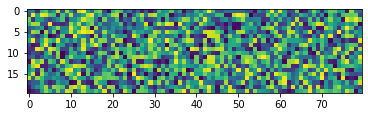

In [35]:
plt.imshow(agent.actor.connections[("In", "Out")].w.numpy().T)

In [36]:
agent.to(device)

In [37]:
trainer = A2CTrainer(num_episodes=10, spikes_to_value=1)#, device=device)

In [38]:
# episode = trainer.play_episode(agent, "CartPole-v0", render=True)

In [39]:
# episode.render_replay("out.gif")

In [40]:
# Image("out.gif")

In [41]:
trainer.fit(agent, "CartPole-v0")

13.0
9.0
13.0
11.0
14.0
11.0
12.0
12.0
14.0
9.0


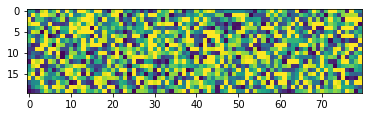

In [42]:
plt.imshow(agent.actor.connections[("In", "Out")].w.numpy().T)

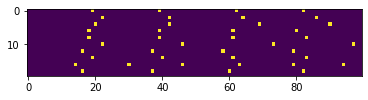

In [32]:
plt.imshow(agent.actor.monitors["Out"].get("s").view(100, -1).t())

In [15]:
episode = trainer.play_episode(agent, "CartPole-v0", render=True)

In [16]:
transition = episode.transitions[0]

In [20]:
agent.run_actor(
    observation=torch.from_numpy(transition.observation),
)

0

In [18]:
trainer.compute_delta(
    agent,
    observation=torch.from_numpy(transition.observation),
    prev_observation=torch.from_numpy(transition.prev_observation),
    reward=transition.reward
)

1.0

In [24]:
agent.run_critic(torch.from_numpy(transition.observation))

50.0

In [25]:
agent.run_prev_critic(torch.from_numpy(transition.prev_observation))

50.0

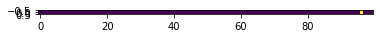

In [54]:
plt.imshow(agent.critique.monitors["Out"].get("s").view(100, -1).t())

In [ ]:
agent.actor.monitors["Out"].get("s").squeeze(1).sum()

In [ ]:
agent.actor.connections[("In", "l1")].w.numpy().mean()

In [ ]:
agent.actor.layers["Out"].shape

In [ ]:
clamp = torch.BoolTensor([0, 1])

In [ ]:
clamp[..., 0] = 1

In [ ]:
clamp